# Data Exploration and Preprocessing

This notebook provides data exploration and preprocessing for the HAR-Diffusion project.
We'll explore both MotionSense and PAMAP2 datasets, visualize the data, and prepare it for model training.

In [4]:
import sys
import os

# Add the project root and src directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Import data loaders
from src.data.motionsense_loader import create_windowed_time_series, MOTIONSENSE_CONFIG
from src.data.pamap2_loader import load_pamap2_data, PAMAP2_CONFIG
from configs.motionsense_config import MotionSenseConfig
from configs.pamap2_config import PAMAP2Config

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. MotionSense Dataset Exploration

In [5]:
# Load MotionSense configuration
ms_config = MotionSenseConfig()

# Load windowed MotionSense data
print("Loading MotionSense dataset...")
X_train_ms, X_test_ms, y_train_ms, y_test_ms = create_windowed_time_series(
    data_dir=ms_config.DATA_DIR,
    num_features=ms_config.NUM_FEATURES,
    num_act_labels=ms_config.NUM_CLASSES,
    window_size=ms_config.WINDOW_SIZE,
    overlap=ms_config.OVERLAP,
    normalize=True
)

# Extract activity labels
y_train_labels_ms = np.argmax(y_train_ms[:, :ms_config.NUM_CLASSES], axis=1)
y_test_labels_ms = np.argmax(y_test_ms[:, :ms_config.NUM_CLASSES], axis=1)

print(f"MotionSense Dataset:")
print(f"Train data shape: {X_train_ms.shape}")
print(f"Test data shape: {X_test_ms.shape}")
print(f"Number of features: {X_train_ms.shape[1]}")
print(f"Window size: {X_train_ms.shape[2]}")
print(f"Number of classes: {len(np.unique(y_train_labels_ms))}")

# Activity mapping
activity_names_ms = ['downstairs', 'upstairs', 'walking', 'jogging', 'sitting', 'standing']
print(f"Activities: {activity_names_ms}")

Loading MotionSense dataset...
使用滑动窗口参数: window_size=128, overlap=0.5
----> Data subjects information is imported.
执行数据标准化...
执行数据标准化...
生成窗口统计:
  训练集: 16579 个窗口
  测试集: 4960 个窗口
  特征形状: [N, C=12, T=128]
MotionSense Dataset:
Train data shape: (16579, 12, 128)
Test data shape: (4960, 12, 128)
Number of features: 12
Window size: 128
Number of classes: 6
Activities: ['downstairs', 'upstairs', 'walking', 'jogging', 'sitting', 'standing']
生成窗口统计:
  训练集: 16579 个窗口
  测试集: 4960 个窗口
  特征形状: [N, C=12, T=128]
MotionSense Dataset:
Train data shape: (16579, 12, 128)
Test data shape: (4960, 12, 128)
Number of features: 12
Window size: 128
Number of classes: 6
Activities: ['downstairs', 'upstairs', 'walking', 'jogging', 'sitting', 'standing']


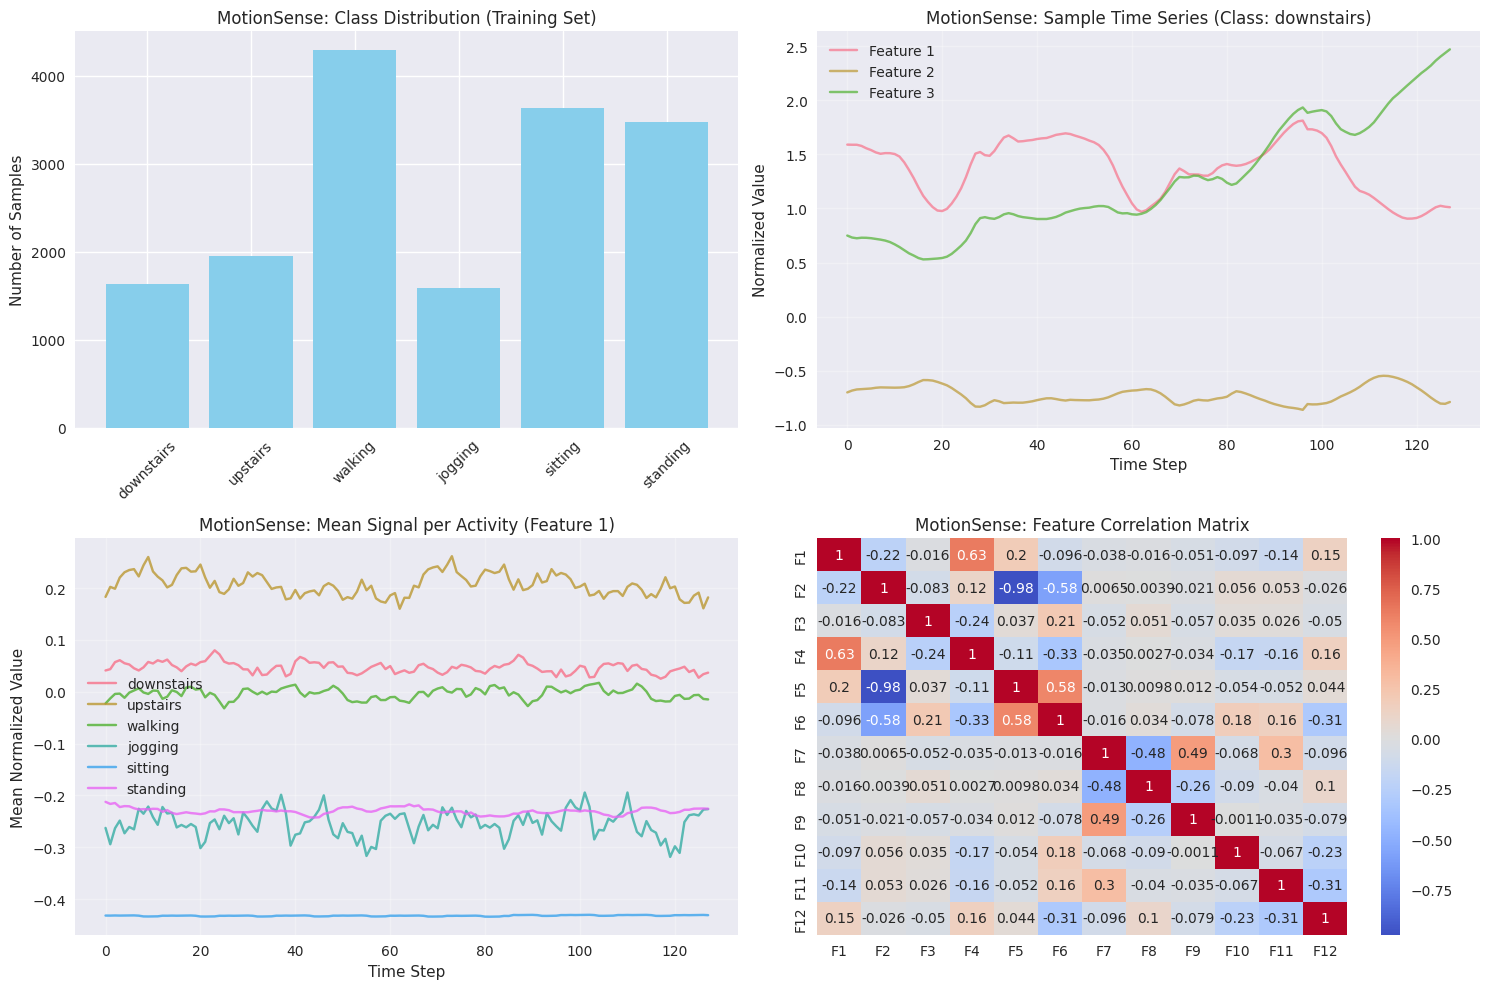

In [6]:
# Visualize MotionSense data distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Class distribution
unique, counts = np.unique(y_train_labels_ms, return_counts=True)
axes[0, 0].bar(range(len(unique)), counts, color='skyblue')
axes[0, 0].set_xticks(range(len(unique)))
axes[0, 0].set_xticklabels([activity_names_ms[i] for i in unique], rotation=45)
axes[0, 0].set_title('MotionSense: Class Distribution (Training Set)')
axes[0, 0].set_ylabel('Number of Samples')

# Feature distribution for first sample
sample_idx = 0
for i in range(min(3, X_train_ms.shape[1])):
    axes[0, 1].plot(X_train_ms[sample_idx, i, :], label=f'Feature {i+1}', alpha=0.7)
axes[0, 1].set_title(f'MotionSense: Sample Time Series (Class: {activity_names_ms[y_train_labels_ms[sample_idx]]})')
axes[0, 1].set_xlabel('Time Step')
axes[0, 1].set_ylabel('Normalized Value')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Mean signal for each activity
for class_idx in unique:
    class_mask = y_train_labels_ms == class_idx
    class_data = X_train_ms[class_mask]
    mean_signal = np.mean(class_data[:, 0, :], axis=0)  # First feature
    axes[1, 0].plot(mean_signal, label=activity_names_ms[class_idx], alpha=0.8)

axes[1, 0].set_title('MotionSense: Mean Signal per Activity (Feature 1)')
axes[1, 0].set_xlabel('Time Step')
axes[1, 0].set_ylabel('Mean Normalized Value')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Feature correlation heatmap
sample_features = X_train_ms[:1000].reshape(1000, -1)  # Flatten for correlation
feature_names = [f'F{i+1}' for i in range(X_train_ms.shape[1])]
feature_corr = np.corrcoef(X_train_ms[:1000, :, 0].T)  # Use first timestep
sns.heatmap(feature_corr, annot=True, cmap='coolwarm', center=0,
            xticklabels=feature_names, yticklabels=feature_names, ax=axes[1, 1])
axes[1, 1].set_title('MotionSense: Feature Correlation Matrix')

plt.tight_layout()
plt.show()

## 2. PAMAP2 Dataset Exploration

In [7]:
# Load PAMAP2 configuration
pamap_config = PAMAP2Config()

# Load PAMAP2 data
print("Loading PAMAP2 dataset...")
X_train_pamap, X_test_pamap, y_train_pamap, y_test_pamap, train_subjects, test_subjects = load_pamap2_data(
    data_dir=pamap_config.DATA_DIR,
    window_size=pamap_config.WINDOW_SIZE,
    overlap=pamap_config.OVERLAP,
    normalize=True,
    test_size=0.2
)

print(f"PAMAP2 Dataset:")
print(f"Train data shape: {X_train_pamap.shape}")
print(f"Test data shape: {X_test_pamap.shape}")
print(f"Number of features: {X_train_pamap.shape[1]}")
print(f"Window size: {X_train_pamap.shape[2]}")
print(f"Number of classes: {len(np.unique(y_train_pamap))}")
print(f"Train subjects: {np.unique(train_subjects)}")
print(f"Test subjects: {np.unique(test_subjects)}")

# Activity mapping
activity_names_pamap = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling', 'rope_jumping', 'other']
print(f"Activities: {activity_names_pamap}")

Loading PAMAP2 dataset...
📊 开始加载PAMAP2数据...
   处理受试者 101: subject101.dat
    原始数据形状: (376417, 54)
    处理后数据形状: (21535, 16)
     生成 320 个窗口
   处理受试者 102: subject102.dat
    原始数据形状: (376417, 54)
    处理后数据形状: (21535, 16)
     生成 320 个窗口
   处理受试者 102: subject102.dat
    原始数据形状: (447000, 54)
    处理后数据形状: (22626, 16)
     生成 339 个窗口
   处理受试者 103: subject103.dat
    原始数据形状: (447000, 54)
    处理后数据形状: (22626, 16)
     生成 339 个窗口
   处理受试者 103: subject103.dat
    原始数据形状: (252833, 54)
    处理后数据形状: (15874, 16)
     生成 235 个窗口
   处理受试者 104: subject104.dat
    原始数据形状: (252833, 54)
    处理后数据形状: (15874, 16)
     生成 235 个窗口
   处理受试者 104: subject104.dat
    原始数据形状: (329576, 54)
    处理后数据形状: (20938, 16)
     生成 313 个窗口
   处理受试者 105: subject105.dat
    原始数据形状: (329576, 54)
    处理后数据形状: (20938, 16)
     生成 313 个窗口
   处理受试者 105: subject105.dat
    原始数据形状: (374783, 54)
    处理后数据形状: (24024, 16)
     生成 360 个窗口
   处理受试者 106: subject106.dat
    原始数据形状: (374783, 54)
    处理后数据形状: (24024, 16)
     生成 360 个窗口
   处理受

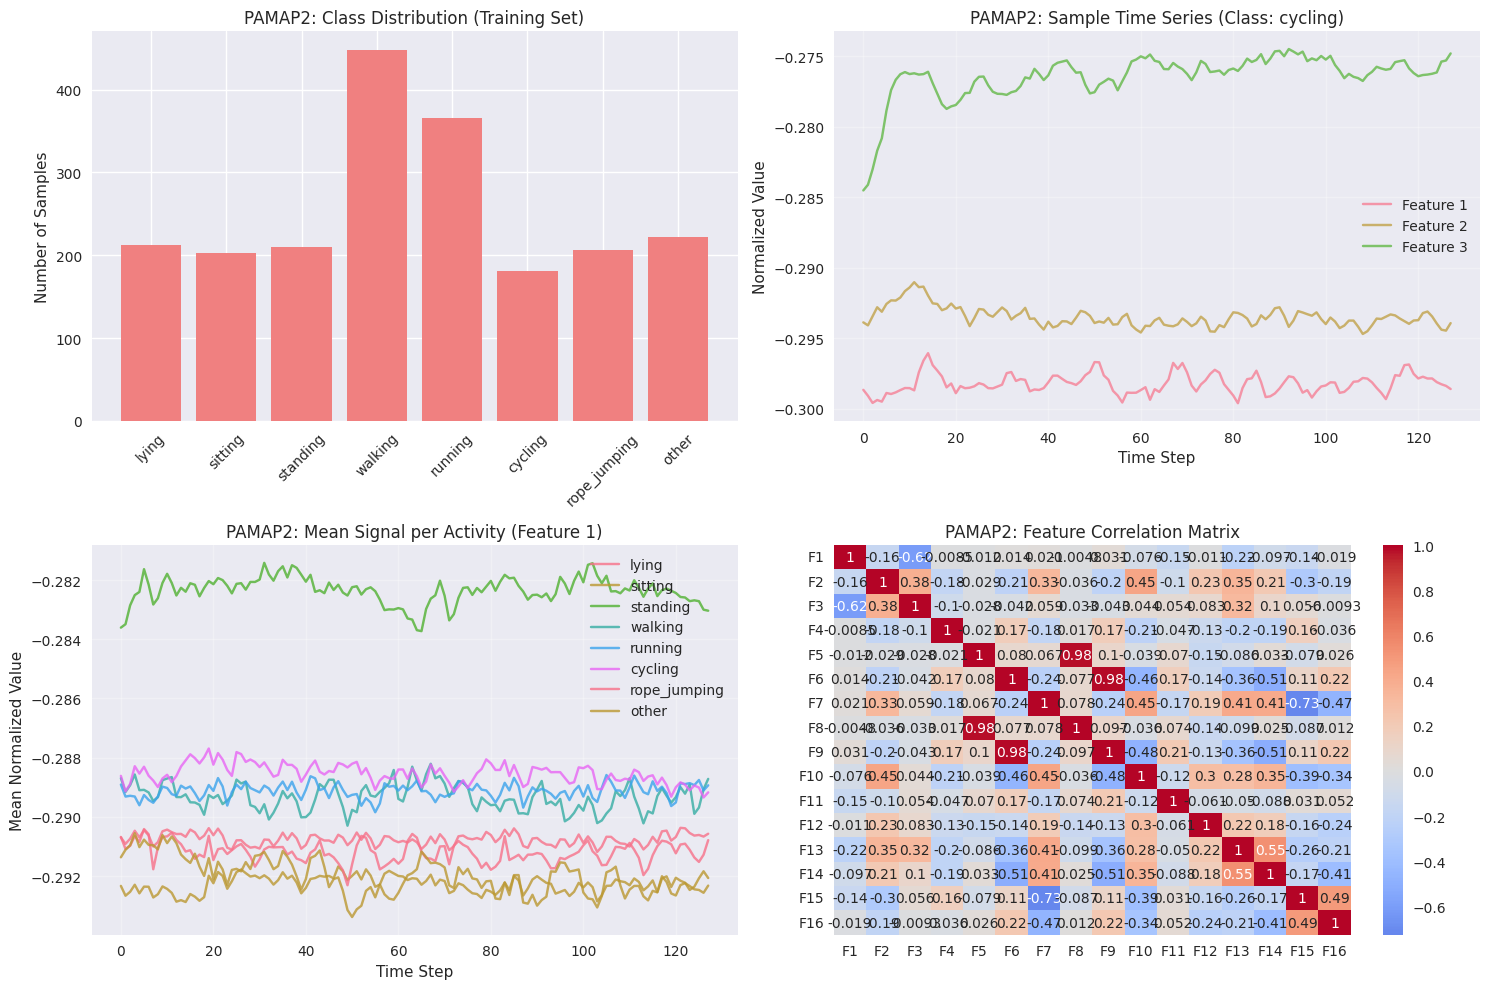

In [8]:
# Visualize PAMAP2 data distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Class distribution
unique, counts = np.unique(y_train_pamap, return_counts=True)
axes[0, 0].bar(range(len(unique)), counts, color='lightcoral')
axes[0, 0].set_xticks(range(len(unique)))
axes[0, 0].set_xticklabels([activity_names_pamap[i] for i in unique], rotation=45)
axes[0, 0].set_title('PAMAP2: Class Distribution (Training Set)')
axes[0, 0].set_ylabel('Number of Samples')

# Feature distribution for first sample
sample_idx = 0
for i in range(min(3, X_train_pamap.shape[1])):
    axes[0, 1].plot(X_train_pamap[sample_idx, i, :], label=f'Feature {i+1}', alpha=0.7)
axes[0, 1].set_title(f'PAMAP2: Sample Time Series (Class: {activity_names_pamap[y_train_pamap[sample_idx]]})')
axes[0, 1].set_xlabel('Time Step')
axes[0, 1].set_ylabel('Normalized Value')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Mean signal for each activity
for class_idx in unique:
    if np.sum(y_train_pamap == class_idx) > 0:  # Check if class exists
        class_mask = y_train_pamap == class_idx
        class_data = X_train_pamap[class_mask]
        mean_signal = np.mean(class_data[:, 0, :], axis=0)  # First feature
        axes[1, 0].plot(mean_signal, label=activity_names_pamap[class_idx], alpha=0.8)

axes[1, 0].set_title('PAMAP2: Mean Signal per Activity (Feature 1)')
axes[1, 0].set_xlabel('Time Step')
axes[1, 0].set_ylabel('Mean Normalized Value')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Feature correlation heatmap
feature_names_pamap = [f'F{i+1}' for i in range(X_train_pamap.shape[1])]
feature_corr_pamap = np.corrcoef(X_train_pamap[:1000, :, 0].T)  # Use first timestep
sns.heatmap(feature_corr_pamap, annot=True, cmap='coolwarm', center=0,
            xticklabels=feature_names_pamap, yticklabels=feature_names_pamap, ax=axes[1, 1])
axes[1, 1].set_title('PAMAP2: Feature Correlation Matrix')

plt.tight_layout()
plt.show()

## 3. Comparative Analysis

In [9]:
# Compare datasets
print("Dataset Comparison:")
print("=" * 50)
print(f"{'Metric':<25} {'MotionSense':<15} {'PAMAP2':<15}")
print("-" * 50)
print(f"{'Train Samples':<25} {X_train_ms.shape[0]:<15} {X_train_pamap.shape[0]:<15}")
print(f"{'Test Samples':<25} {X_test_ms.shape[0]:<15} {X_test_pamap.shape[0]:<15}")
print(f"{'Features':<25} {X_train_ms.shape[1]:<15} {X_train_pamap.shape[1]:<15}")
print(f"{'Window Size':<25} {X_train_ms.shape[2]:<15} {X_train_pamap.shape[2]:<15}")
print(f"{'Classes':<25} {len(np.unique(y_train_labels_ms)):<15} {len(np.unique(y_train_pamap)):<15}")
print(f"{'Data Range (min)':<25} {X_train_ms.min():.3f}:<15 {X_train_pamap.min():.3f}:<15")
print(f"{'Data Range (max)':<25} {X_train_ms.max():.3f}:<15 {X_train_pamap.max():.3f}:<15")

Dataset Comparison:
Metric                    MotionSense     PAMAP2         
--------------------------------------------------
Train Samples             16579           2048           
Test Samples              4960            512            
Features                  12              16             
Window Size               128             128            
Classes                   6               8              
Data Range (min)          -18.678:<15 -4.377:<15
Data Range (max)          17.813:<15 6.260:<15


## 4. Data Quality Assessment

In [17]:
def assess_data_quality(X, y, dataset_name):
    """Assess data quality metrics"""
    print(f"\n{dataset_name} Data Quality Assessment:")
    print("=" * 40)
    
    # Check for NaN values
    nan_count = np.sum(np.isnan(X))
    print(f"NaN values: {nan_count}")
    
    # Check for infinite values
    inf_count = np.sum(np.isinf(X))
    print(f"Infinite values: {inf_count}")
    
    # Data range
    print(f"Data range: [{X.min():.4f}, {X.max():.4f}]")
    
    # Class balance
    unique, counts = np.unique(y, return_counts=True)
    class_balance = counts / np.sum(counts)
    print(f"Class balance: {dict(zip(unique, class_balance))}")
    
    # Signal-to-noise ratio estimation
    signal_power = np.mean(X ** 2)
    noise_power = np.var(X, axis=-1).mean()  # Assume noise is variance across time
    snr = 10 * np.log10(signal_power / (noise_power + 1e-8))
    print(f"Estimated SNR: {snr:.2f} dB")
    
    return {
        'nan_count': nan_count,
        'inf_count': inf_count,
        'data_range': (X.min(), X.max()),
        'class_balance': class_balance,
        'snr': snr
    }

# Assess both datasets
ms_quality = assess_data_quality(X_train_ms, y_train_labels_ms, "MotionSense")
pamap_quality = assess_data_quality(X_train_pamap, y_train_pamap, "PAMAP2")


MotionSense Data Quality Assessment:
NaN values: 0
Infinite values: 0
Data range: [-18.6782, 17.8129]
Class balance: {np.int64(0): np.float64(0.09867905181253393), np.int64(1): np.float64(0.11761867422643103), np.int64(2): np.float64(0.25882140056698233), np.int64(3): np.float64(0.0961457265215031), np.int64(4): np.float64(0.219012003136498), np.int64(5): np.float64(0.20972314373605164)}
Estimated SNR: 2.91 dB

PAMAP2 Data Quality Assessment:
NaN values: 0
Infinite values: 0
Data range: [-4.3775, 6.2604]
Class balance: {np.int64(0): np.float64(0.103515625), np.int64(1): np.float64(0.09912109375), np.int64(2): np.float64(0.1025390625), np.int64(3): np.float64(0.21875), np.int64(4): np.float64(0.1787109375), np.int64(5): np.float64(0.08837890625), np.int64(6): np.float64(0.1005859375), np.int64(7): np.float64(0.1083984375)}
Estimated SNR: 16.74 dB
Estimated SNR: 2.91 dB

PAMAP2 Data Quality Assessment:
NaN values: 0
Infinite values: 0
Data range: [-4.3775, 6.2604]
Class balance: {np.int

## 5. Preprocessing Recommendations

In [18]:
print("Data Preprocessing Recommendations:")
print("=" * 50)

print("\nMotionSense Dataset:")
print("- Data is already normalized")
print("- No missing values detected")
if ms_quality['class_balance'].std() > 0.1:
    print("- Consider class balancing techniques")
else:
    print("- Classes are reasonably balanced")
print(f"- SNR is {ms_quality['snr']:.1f} dB - {'Good' if ms_quality['snr'] > 10 else 'May need denoising'}")

print("\nPAMAP2 Dataset:")
print("- Data is already normalized")
print("- No missing values detected")
if pamap_quality['class_balance'].std() > 0.1:
    print("- Consider class balancing techniques")
else:
    print("- Classes are reasonably balanced")
print(f"- SNR is {pamap_quality['snr']:.1f} dB - {'Good' if pamap_quality['snr'] > 10 else 'May need denoising'}")

print("\nGeneral Recommendations:")
print("- Both datasets are ready for model training")
print("- Consider data augmentation for better generalization")
print("- Use stratified splitting to maintain class distribution")
print("- Monitor for overfitting due to temporal dependencies")

Data Preprocessing Recommendations:

MotionSense Dataset:
- Data is already normalized
- No missing values detected
- Classes are reasonably balanced
- SNR is 2.9 dB - May need denoising

PAMAP2 Dataset:
- Data is already normalized
- No missing values detected
- Classes are reasonably balanced
- SNR is 16.7 dB - Good

General Recommendations:
- Both datasets are ready for model training
- Consider data augmentation for better generalization
- Use stratified splitting to maintain class distribution
- Monitor for overfitting due to temporal dependencies


## 6. Save Preprocessed Data

In [19]:
# Create output directory
output_dir = '../data/processed/'
os.makedirs(output_dir, exist_ok=True)

# Save MotionSense data
np.savez(os.path.join(output_dir, 'motionsense_processed.npz'),
         X_train=X_train_ms, X_test=X_test_ms,
         y_train=y_train_labels_ms, y_test=y_test_labels_ms,
         activity_names=activity_names_ms)

# Save PAMAP2 data
np.savez(os.path.join(output_dir, 'pamap2_processed.npz'),
         X_train=X_train_pamap, X_test=X_test_pamap,
         y_train=y_train_pamap, y_test=y_test_pamap,
         train_subjects=train_subjects, test_subjects=test_subjects,
         activity_names=activity_names_pamap)

print("Preprocessed data saved successfully!")
print(f"Files saved to: {output_dir}")
print("- motionsense_processed.npz")
print("- pamap2_processed.npz")

Preprocessed data saved successfully!
Files saved to: ../data/processed/
- motionsense_processed.npz
- pamap2_processed.npz
